In [1]:
import math
import torch
import pickle
import torch.cuda
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision.datasets as dsets
import os
from utils.BBBConvmodel import BBBAlexNet, BBBLeNet, BBB3Conv3FC, BBBVGG16
from utils.BBBlayers import GaussianVariationalInference
import numpy as np
from scipy.stats import norm, cauchy
cuda = torch.cuda.is_available()
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from scipy import stats
from scipy.optimize import minimize
import math

In [2]:
batch_size = 32
lr = 0.001
dataset = 'CIFAR-10'
network = 'lenet'
if dataset == 'MNIST':
    model = torch.load("../results/{}_withbias_b{}_lr{}_{}.pth".format(network, batch_size, lr, dataset))
elif dataset == 'CIFAR-10':
    model = BBBLeNet(outputs=10, inputs=3)
    model_name = 'lenet5'
    num_epochs = 50
    model.load_state_dict(torch.load('../model_with_bias/model{}_param_epoch{}_lr{}_bs{}.pkl'.format(model_name,num_epochs,lr,batch_size), map_location='cpu'))
net = BBBLeNet
num_samples = 10
beta_type = "Blundell"

In [3]:
# dimensions of input and output
if dataset == 'MNIST':    # train with MNIST
    outputs = 10
    inputs = 1
elif dataset == 'CIFAR-10':  # train with CIFAR-10
    outputs = 10
    inputs = 3
elif dataset == 'CIFAR-100':    # train with CIFAR-100
    outputs = 100
    inputs = 3

if net == BBBLeNet or BBB3Conv3FC:
    resize = 32
elif net == BBBAlexNet:
    resize = 227

In [4]:
'''
LOADING DATASET
'''

if dataset == 'MNIST':
    transform = transforms.Compose([transforms.Resize((resize, resize)), transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = dsets.MNIST(root="data", download=True, transform=transform)
    val_dataset = dsets.MNIST(root="data", download=True, train=False, transform=transform)

elif dataset == 'CIFAR-100':
    transform = transforms.Compose([transforms.Resize((resize, resize)), transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    train_dataset = dsets.CIFAR100(root="data", download=True, transform=transform)
    val_dataset = dsets.CIFAR100(root='data', download=True, train=False, transform=transform)

elif dataset == 'CIFAR-10':
    transform = transforms.Compose([transforms.Resize((resize, resize)), transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    train_dataset = dsets.CIFAR10(root="data", download=True, transform=transform)
    val_dataset = dsets.CIFAR10(root='data', download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
loader_val = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
model.state_dict().keys()

odict_keys(['conv1.qw_mean', 'conv1.qw_logvar', 'conv1.qb_mean', 'conv1.qb_logvar', 'conv1.conv_qw_mean', 'conv1.conv_qw_si', 'conv1.log_alpha', 'conv2.qw_mean', 'conv2.qw_logvar', 'conv2.qb_mean', 'conv2.qb_logvar', 'conv2.conv_qw_mean', 'conv2.conv_qw_si', 'conv2.log_alpha', 'fc1.qw_mean', 'fc1.qw_logvar', 'fc1.qb_mean', 'fc1.qb_logvar', 'fc1.fc_qw_mean', 'fc1.fc_qw_si', 'fc1.log_alpha', 'fc2.qw_mean', 'fc2.qw_logvar', 'fc2.qb_mean', 'fc2.qb_logvar', 'fc2.fc_qw_mean', 'fc2.fc_qw_si', 'fc2.log_alpha', 'fc3.qw_mean', 'fc3.qw_logvar', 'fc3.qb_mean', 'fc3.qb_logvar', 'fc3.fc_qw_mean', 'fc3.fc_qw_si', 'fc3.log_alpha', 'layers.0.qw_mean', 'layers.0.qw_logvar', 'layers.0.qb_mean', 'layers.0.qb_logvar', 'layers.0.conv_qw_mean', 'layers.0.conv_qw_si', 'layers.0.log_alpha', 'layers.3.qw_mean', 'layers.3.qw_logvar', 'layers.3.qb_mean', 'layers.3.qb_logvar', 'layers.3.conv_qw_mean', 'layers.3.conv_qw_si', 'layers.3.log_alpha', 'layers.7.qw_mean', 'layers.7.qw_logvar', 'layers.7.qb_mean', 'layers

# 合并weights

In [7]:
if network == "lenet" or network == "lenet5":
    w_name = ['layers.0.qw_', 'layers.3.qw_', 'layers.7.qw_','layers.9.qw_', 'layers.11.qw_']
    b_name = ['layers.0.qb_', 'layers.3.qb_', 'layers.7.qb_','layers.9.qb_', 'layers.11.qb_']
elif network == "vgg16":
    w_name = ['layers.0.qw_', 'layers.2.qw_', 'layers.4.qw_','layers.6.qw_', 'layers.8.qw_', 
              'layers.10.qw_', 'layers.12.qw_', 'layers.14.qw_', 'layers.16.qw_', 'layers.18.qw_',
            'layers.20.qw_', 'layers.22.qw_', 'layers.24.qw_', 'layers.27.qw_', 'layers.30.qw_', 'layers.33.qw_']
    b_name = ['layers.0.qb_', 'layers.2.qb_', 'layers.4.qb_','layers.6.qb_', 'layers.8.qb_', 
              'layers.10.qb_', 'layers.12.qb_', 'layers.14.qb_', 'layers.16.qb_', 'layers.18.qb_',
            'layers.20.qb_', 'layers.22.qb_', 'layers.24.qb_', 'layers.27.qb_', 'layers.30.qb_', 'layers.33.qb_']

In [8]:
model = model.cpu()

In [9]:
whole_w = []
for (i, j) in zip(w_name, b_name):
    whole_w.append(model.state_dict()['{}mean'.format(i)].numpy().ravel())
    whole_w.append(model.state_dict()['{}mean'.format(j)].numpy().ravel())
whole_w = np.concatenate(whole_w)

In [10]:
len(whole_w)

62006

In [11]:
len(whole_w[np.abs(whole_w) <= 1e-2])

6263

# 神经网络精度计算函数

In [12]:
vi = GaussianVariationalInference(torch.nn.CrossEntropyLoss())

def run_epoch(loader, epoch, is_training=False, model=model):
    m = math.ceil(len(loader.dataset) / loader.batch_size)

    accuracies = []
    likelihoods = []
    kls = []
    losses = []

    for i, (images, labels) in enumerate(loader):
        # # Repeat samples (Casper's trick)
        # x = images.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        # y = labels.repeat(num_samples)
        x = images.view(-1, inputs, resize, resize)
        y = labels
        if cuda:
            x = x.cuda()
            y = y.cuda()

        if beta_type == "Blundell":
            beta = 2 ** (m - (i + 1)) / (2 ** m - 1)
        elif beta_type == "Soenderby":
            beta = min(epoch / (num_epochs//4), 1)
        elif beta_type == "Standard":
            beta = 1 / m
        else:
            beta = 0

        logits, kl = model.probforward(x)
        loss = vi(logits, y, kl, beta)
        ll = -loss.data.mean() + beta*kl.data.mean()

        if is_training:
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

        _, predicted = logits.max(1)
        accuracy = (predicted.data.cpu() == y.cpu()).float().mean()

        accuracies.append(accuracy)
        losses.append(loss.data.mean())
        kls.append(beta*kl.data.mean())
        likelihoods.append(ll)

    diagnostics = {'loss': sum(losses)/len(losses),
                   'acc': sum(accuracies)/len(accuracies),
                   'kl': sum(kls)/len(kls),
                   'likelihood': sum(likelihoods)/len(likelihoods)}

    return diagnostics

In [13]:
model = model.cuda()
diagnostics_val = run_epoch(loader_val, epoch=1)

logits tensor([[ -6.0017,  -5.8115,  -1.6659,   2.9183,  -1.1884,   4.6155,  -1.4969,
           3.5454,  -3.9437,  -5.6008],
        [  2.2578,  -0.1603,  -5.1051,  -5.2433,  -7.2700,  -6.7996,  -7.3498,
          -7.4176,   4.4658,  -1.3270],
        [ -0.3362,   0.1468,  -2.3734,  -3.9765,  -3.9967,  -4.7714,  -3.5503,
          -4.2019,   0.3688,   1.2010],
        [  4.4529,  -2.3299,  -1.2109,  -3.7113,  -0.1629,  -6.9514,  -9.8267,
          -7.2427,   0.5896,  -5.2163],
        [ -4.4656,  -5.4121,   1.8372,   1.9164,   6.3001,  -1.2885,   1.5033,
          -3.1083,  -5.6901,  -6.9001],
        [ -4.7653,  -2.3016,  -1.3866,   1.7603,   0.6343,   0.3715,   4.4504,
          -2.9651,  -4.5804,  -4.2382],
        [  1.2472,   2.3177,  -5.8250,  -5.1694,  -5.9117,  -5.5195,  -6.2703,
          -5.3334,  -6.0706,   4.6633],
        [ -4.9388,  -4.8572,   5.8437,  -0.8773,  -1.1028,  -5.7855,   5.4691,
          -5.8976,  -6.8275,  -1.7430],
        [ -3.8048,  -4.0816,  -1.5382,   

In [14]:
diagnostics_val

{'loss': tensor(143.7385, device='cuda:0'),
 'acc': tensor(0.6072),
 'kl': tensor(142.2631, device='cuda:0'),
 'likelihood': tensor(-1.4754, device='cuda:0')}

In [15]:
def evaluate(loader, cpr_model, epoch=1):
    m = math.ceil(len(loader.dataset) / loader.batch_size)

    accuracies = []

    for i, (images, labels) in enumerate(loader):
        # # Repeat samples (Casper's trick)
        # x = images.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        # y = labels.repeat(num_samples)

        x = images.view(-1, inputs, resize, resize)
        y = labels

        if cuda:
            x = x.cuda()
            y = y.cuda()

        logits = cpr_model(x)
        _, predicted = torch.max(logits.data, 1)
        accuracy = (predicted.data.cpu() == y.cpu()).float().mean()

        accuracies.append(accuracy)

    diagnostics = {'acc': sum(accuracies)/len(accuracies)}

    return diagnostics

把BNN的weights套进确定性网络，测试精度

In [16]:
uncompressed_list = []
for (i, j) in zip(w_name, b_name):
    # w
    vecs_u1 = model.state_dict()['{}mean'.format(i)]
    uncompressed_list.append(vecs_u1)
    # b
    vecs_u2 = torch.zeros_like(model.state_dict()['{}mean'.format(j)])
    uncompressed_list.append(vecs_u2)

if network == "lenet":
    # lenet
    from model import lenet
    cpr_model=lenet(inputs)
elif network == "vgg16":
    from model import VGG16
    cpr_model = VGG16(inputs)
name_uncpr=cpr_model.state_dict().keys()
uncpr_state_dict = dict(zip(name_uncpr, uncompressed_list))
cpr_model.load_state_dict(uncpr_state_dict)
# 用压缩后的模型计算loss，acc等
cpr_model = cpr_model.cuda()
diagnostics_uncpr_val = evaluate(loader_val, cpr_model=cpr_model)

In [17]:
diagnostics_uncpr_val

{'acc': tensor(0.5328)}

In [18]:
method = "gaussian"
# method = "gg"
# method = "gmm"
# method = "cauchy"

# 用不同的lambda和N压缩

## global

In [19]:
def compress_coordinates(means, stds, lamb, bitlengths, codepoints):
    # N = len(means.ravel()) = len(stds.ravel())
    # C = len(codepoints)
    optima = np.empty_like(means)
    optima_lengths = np.empty_like(means, dtype=int)
    for i in range(0, 10000000, 100000):
        if i % 100000 == 0:
            print(i / 1000000)
        squared_errors = (codepoints[np.newaxis, :] - means.ravel()[i:i+100000, np.newaxis])**2
            # shape (N, C)
        weighted_penalties = (2 * lamb) * stds.ravel()[i:i+100000, np.newaxis]**2 * bitlengths[np.newaxis, :]
            # shape (N, C)
        optima_idxs = np.argmin(squared_errors + weighted_penalties, axis=1)
        optima.ravel()[i:i+100000] = codepoints[optima_idxs]
        optima_lengths.ravel()[i:i+100000] = bitlengths[optima_idxs]
    return optima, optima_lengths

In [20]:
if method == "gaussian":
    # gaussian
    empirical_mean = np.mean(whole_w)
    empirical_std = np.std(whole_w)

elif method == "gg":
    # generalized gaussian
    def generalized_gaussian(params, data):
        beta, mu, alpha = params
        n = len(data)
        # log_likelihood = -n*np.log(2*alpha*math.gamma(1/beta)) - np.sum(np.abs((data - mu)/(np.sqrt(2)*alpha))**beta)
        log_likelihood = n*(np.log(beta)-np.log(2)-np.log(alpha)-np.log(math.gamma(1/beta)))-np.sum((np.abs(data - mu)/alpha)**beta)
        return -log_likelihood

    def estimate_generalized_gaussian_parameters(data):
        # Initial parameter guess
        initial_params = [1, np.mean(data), np.std(data)]

        # Define the optimization function
        optimization_func = lambda params: generalized_gaussian(params, data)

        # Perform the optimization
        result = minimize(optimization_func, initial_params, method='Nelder-Mead')

        # Extract the optimized parameters
        beta, mu, alpha = result.x

        return beta, mu, alpha
    beta_est, mu_est, alpha_est = estimate_generalized_gaussian_parameters(whole_w)

    def log_GGD_pdf (mu,alpha,beta,x):
        return np.log(beta)-np.log(2)-np.log(alpha)-np.log(math.gamma(1/beta))-np.sum(np.abs((x - mu)/alpha)**beta)
    def quantile_GGD(alpha,beta,mu,p):
        return np.sign(p-0.5)*((alpha**beta)*stats.gamma.ppf(2*np.abs(p-0.5),1/beta))**(1/beta)+mu
elif method == "gmm":
    import random
    from sklearn.mixture import GaussianMixture
    import scipy.optimize as optimize
    # gmm
    # 设置随机种子
    seed = 42
    np.random.seed(seed)
    random.seed(seed)

    # 定义要尝试的n_components值
    n_min = 2
    n_components_range = range(n_min, 6)

    # 初始化信息准则列表
    aic_scores = []
    bic_scores = []

    # 计算每个n_components值上的信息准则值
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(whole_w.reshape(-1,1))
        # aic_scores.append(gmm.aic(whole_w.reshape(-1,1)))
        bic_scores.append(gmm.bic(whole_w.reshape(-1,1)))

    # 选择具有最小信息准则值的n_components值
    # best_n_components_aic = np.argmin(aic_scores) + n_min
    best_n_components_bic = np.argmin(bic_scores) + n_min

    # print("Best n_components (AIC):", best_n_components_aic)
    print("Best n_components (BIC):", best_n_components_bic)

    gmm = GaussianMixture(n_components=best_n_components_bic)
    gmm.fit(whole_w.reshape(-1,1))

    # 获取每个混合分量的参数（均值、标准差、权重）
    means = gmm.means_.squeeze()
    covs = gmm.covariances_.squeeze()  #注意covs是方差，不是标准差
    pis = gmm.weights_.squeeze()
    def F(x, w, u, s):
        return sum(w * norm.cdf(x, loc=u, scale=s))

    def F_inv(p, w, u, s, br=(-1000, 1000)):
        G = lambda x: F(x, w, u, s) - p
        result = optimize.root_scalar(G, bracket=br)
        return result.root
elif method == "cauchy":
    # cauchy
    cauchy_loc, cauchy_scale = cauchy.fit(whole_w)

In [21]:
from collections import Counter
def empirical_entropy(values):
    counts = np.array(list(Counter(values.ravel()).values()))
    total_counts = counts.sum()
    return total_counts * np.log2(total_counts) - counts.dot(np.log2(counts))

In [22]:
def compress_model(lamb, strategy, max_codepoint_length=10):
    compressed_add_len = 0
    compressed_list = []
    quantized = []
    for (i, j) in zip(w_name, b_name):
        # w
        vecs_u1 = model.state_dict()['{}mean'.format(i)].numpy()
        stds_u1 = np.exp(model.state_dict()['{}logvar'.format(i)].numpy())
        # b
        vecs_u2 = model.state_dict()['{}mean'.format(j)].numpy()
        stds_u2 = np.exp(model.state_dict()['{}logvar'.format(j)].numpy())

        if strategy == "global":
            if method == "gaussian":
                global empirical_mean, empirical_std
                codepoints_and_lengths = [
                    (scipy.stats.norm.ppf(codepoint_xi, loc=empirical_mean, scale=empirical_std), length)
                    for length in range(max_codepoint_length+1)
                    for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                ]
            elif method == "gg":
                global alpha_est,beta_est,mu_est
                codepoints_and_lengths = [
                    (quantile_GGD(alpha_est,beta_est,mu_est,codepoint_xi), length)
                    for length in range(max_codepoint_length+1)
                    for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                ]
            elif method == "gmm":
                global pis, means, covs
                codepoints_and_lengths = [
                    (F_inv(codepoint_xi, pis, means, np.sqrt(covs)), length)
                    for length in range(max_codepoint_length+1)
                    for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                ]
            elif method == "cauchy":
                global cauchy_loc, cauchy_scale
                codepoints_and_lengths = [
                    (scipy.stats.cauchy.ppf(codepoint_xi, loc=cauchy_loc, scale=cauchy_scale), length)
                    for length in range(max_codepoint_length+1)
                    for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                ]
            else:
                print('method not found!')
                break
        if strategy == "layer-wise":
            # 先把w和b合并在一起再拟合
            vecs_u = np.concatenate([vecs_u1.ravel(), vecs_u2.ravel()])
            if method == "gaussian":
                empirical_mean = np.mean(vecs_u)
                empirical_std = np.std(vecs_u)
                codepoints_and_lengths = [
                    (scipy.stats.norm.ppf(codepoint_xi, loc=empirical_mean, scale=empirical_std), length)
                    for length in range(max_codepoint_length+1)
                    for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                ]
            elif method == "gg":
                beta_est, mu_est, alpha_est = estimate_generalized_gaussian_parameters(vecs_u)
                codepoints_and_lengths = [
                    (quantile_GGD(alpha_est,beta_est,mu_est,codepoint_xi), length)
                    for length in range(max_codepoint_length+1)
                    for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                ]
            elif method == "gmm":
                # 拟合gmm
                # 定义要尝试的n_components值
                n_min = 2
                n_components_range = range(n_min, 6)

                # 初始化信息准则列表
                aic_scores = []

                # 计算每个n_components值上的信息准则值
                for n_components in n_components_range:
                    gmm = GaussianMixture(n_components=n_components)
                    gmm.fit(vecs_u.reshape(-1,1))
                    aic_scores.append(gmm.aic(vecs_u.reshape(-1,1)))
                    # bic_scores.append(gmm.bic(vecs_u.reshape(-1,1)))

                # 选择具有最小信息准则值的n_components值
                best_n_components_aic = np.argmin(aic_scores) + n_min
                # best_n_components_bic = np.argmin(bic_scores) + n_min

                print("Best n_components (AIC):", best_n_components_aic)
                # print("Best n_components (BIC):", best_n_components_bic)

                gmm = GaussianMixture(n_components=best_n_components_aic)
                gmm.fit(vecs_u.reshape(-1,1))

                # 获取每个混合分量的参数（均值、标准差、权重）
                means = gmm.means_.squeeze()
                covs = gmm.covariances_.squeeze()  #注意covs是方差，不是标准差
                pis = gmm.weights_.squeeze()

                codepoints_and_lengths = [
                    (F_inv(codepoint_xi, pis, means, np.sqrt(covs)), length)
                    for length in range(max_codepoint_length+1)
                    for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                ]
            elif method == "cauchy":
                cauchy_loc, cauchy_scale = cauchy.fit(vecs_u.ravel())
                codepoints_and_lengths = [
                    (scipy.stats.cauchy.ppf(codepoint_xi, loc=cauchy_loc, scale=cauchy_scale), length)
                    for length in range(max_codepoint_length+1)
                    for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                ]
            else:
                print("method not found!")
                break
        codepoints = np.array([codepoint for codepoint, _ in codepoints_and_lengths])
        lengths = np.array([length for _, length in codepoints_and_lengths])
        # compress w
        compressed1, cpr_len1 = compress_coordinates(vecs_u1,stds_u1,lamb,lengths,codepoints)
        quantized.append(compressed1.flatten())
        compressed1 = torch.from_numpy(compressed1)
        compressed_list.append(compressed1)
        compressed_add_len += np.sum(cpr_len1)
        # compress b
        compressed2, cpr_len2 = compress_coordinates(vecs_u2,stds_u2,lamb,lengths,codepoints)
        quantized.append(compressed2.flatten())
        compressed2 = torch.from_numpy(compressed2)
        compressed_list.append(compressed2)
        compressed_add_len += np.sum(cpr_len2)

    if network == "lenet":
        # lenet
        from model import lenet
        cpr_model=lenet(inputs)
    elif network == "vgg16":
        from model import VGG16
        cpr_model = VGG16(inputs)
    name_cpr=cpr_model.state_dict().keys()
    cpr_state_dict = dict(zip(name_cpr, compressed_list))
    cpr_model.load_state_dict(cpr_state_dict)
    # 用压缩后的模型计算loss，acc等
    cpr_model = cpr_model.cuda()
    diagnostics_cpr_val = evaluate(loader_val, cpr_model=cpr_model)
    acc = diagnostics_cpr_val['acc'].numpy()
    # 计算compressed_AC_len
    if strategy == "global":
        quantized = np.concatenate(quantized)
        compressed_AC_len = empirical_entropy(quantized)
    elif strategy == "layer-wise":
        quantized = np.concatenate(quantized)
        compressed_AC_len = empirical_entropy(quantized)
        # compressed_AC_len = 0
        # for _ in quantized:
        #     compressed_AC_len += empirical_entropy(_)
    # compressed_AC_len是最后用AC再编码，compressed_add_len是直接叠加
    print("lamb=", lamb, "max_codepoint_length", max_codepoint_length, "strategy=", strategy)
    print("acc=",acc)
    print("compressed_AC_len",compressed_AC_len)
    print("compressed_add_len",compressed_add_len)
    return acc, compressed_AC_len, compressed_add_len

----test

In [23]:
results = [['full', 'full', diagnostics_val['acc'].numpy(), 'None', 'None', 'None']]
compressed_len_list = []
lambs = [1]
bitlengths = [10]
strategies = ['global', 'layer-wise']

model = model.cpu()

for strategy in strategies:
    for max_codepoint_length in bitlengths:
        for lamb in lambs:
            acc, compressed_AC_len, compressed_add_len = compress_model(lamb, strategy, max_codepoint_length)
            results.append([max_codepoint_length, lamb, acc, compressed_AC_len, compressed_add_len, strategy])

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9


KeyboardInterrupt: 

In [ ]:
results

[['full', 'full', array(0.98871803, dtype=float32), 'None', 'None', 'None'],
 [10,
  1,
  array(0.9897165, dtype=float32),
  183820.68305363157,
  137674,
  'global'],
 [10,
  1,
  array(0.9876198, dtype=float32),
  178676.4439769967,
  53377,
  'layer-wise']]

In [ ]:
strategy = "global"

In [ ]:
compressed_add_len = 0
compressed_list = []
quantized = []
for (i, j) in zip(w_name, b_name):
    # w
    vecs_u1 = model.state_dict()['{}mean'.format(i)].numpy()
    stds_u1 = np.exp(model.state_dict()['{}logvar'.format(i)].numpy())
    # b
    vecs_u2 = model.state_dict()['{}mean'.format(j)].numpy()
    stds_u2 = np.exp(model.state_dict()['{}logvar'.format(j)].numpy())

    if strategy == "global":
        if method == "gaussian":
            global empirical_mean, empirical_std
            codepoints_and_lengths = [
                (scipy.stats.norm.ppf(codepoint_xi, loc=empirical_mean, scale=empirical_std), length)
                for length in range(max_codepoint_length+1)
                for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
            ]
        elif method == "gg":
            global alpha_est,beta_est,mu_est
            codepoints_and_lengths = [
                (quantile_GGD(alpha_est,beta_est,mu_est,codepoint_xi), length)
                for length in range(max_codepoint_length+1)
                for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
            ]
        elif method == "gmm":
            global pis, means, covs
            codepoints_and_lengths = [
                (F_inv(codepoint_xi, pis, means, np.sqrt(covs)), length)
                for length in range(max_codepoint_length+1)
                for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
            ]
        elif method == "cauchy":
            global cauchy_loc, cauchy_scale
            codepoints_and_lengths = [
                (scipy.stats.cauchy.ppf(codepoint_xi, loc=cauchy_loc, scale=cauchy_scale), length)
                for length in range(max_codepoint_length+1)
                for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
            ]
        else:
            print('method not found!')
            break
    if strategy == "layer-wise":
        # 先把w和b合并在一起再拟合
        vecs_u = np.concatenate([vecs_u1.ravel(), vecs_u2.ravel()])
        if method == "gaussian":
            empirical_mean = np.mean(vecs_u)
            empirical_std = np.std(vecs_u)
            codepoints_and_lengths = [
                (scipy.stats.norm.ppf(codepoint_xi, loc=empirical_mean, scale=empirical_std), length)
                for length in range(max_codepoint_length+1)
                for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
            ]
        elif method == "gg":
            beta_est, mu_est, alpha_est = estimate_generalized_gaussian_parameters(vecs_u)
            codepoints_and_lengths = [
                (quantile_GGD(alpha_est,beta_est,mu_est,codepoint_xi), length)
                for length in range(max_codepoint_length+1)
                for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
            ]
        elif method == "gmm":
            # 拟合gmm
            # 定义要尝试的n_components值
            n_min = 2
            n_components_range = range(n_min, 6)

            # 初始化信息准则列表
            aic_scores = []

            # 计算每个n_components值上的信息准则值
            for n_components in n_components_range:
                gmm = GaussianMixture(n_components=n_components)
                gmm.fit(vecs_u.reshape(-1,1))
                aic_scores.append(gmm.aic(vecs_u.reshape(-1,1)))
                # bic_scores.append(gmm.bic(vecs_u.reshape(-1,1)))

            # 选择具有最小信息准则值的n_components值
            best_n_components_aic = np.argmin(aic_scores) + n_min
            # best_n_components_bic = np.argmin(bic_scores) + n_min

            print("Best n_components (AIC):", best_n_components_aic)
            # print("Best n_components (BIC):", best_n_components_bic)

            gmm = GaussianMixture(n_components=best_n_components_aic)
            gmm.fit(vecs_u.reshape(-1,1))

            # 获取每个混合分量的参数（均值、标准差、权重）
            means = gmm.means_.squeeze()
            covs = gmm.covariances_.squeeze()  #注意covs是方差，不是标准差
            pis = gmm.weights_.squeeze()

            codepoints_and_lengths = [
                (F_inv(codepoint_xi, pis, means, np.sqrt(covs)), length)
                for length in range(max_codepoint_length+1)
                for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
            ]
        elif method == "cauchy":
            cauchy_loc, cauchy_scale = cauchy.fit(vecs_u.ravel())
            codepoints_and_lengths = [
                (scipy.stats.cauchy.ppf(codepoint_xi, loc=cauchy_loc, scale=cauchy_scale), length)
                for length in range(max_codepoint_length+1)
                for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
            ]
        else:
            print("method not found!")
            break
    codepoints = np.array([codepoint for codepoint, _ in codepoints_and_lengths])
    lengths = np.array([length for _, length in codepoints_and_lengths])
    # compress w
    compressed1, cpr_len1 = compress_coordinates(vecs_u1,stds_u1,lamb,lengths,codepoints)
    quantized.append(compressed1.flatten())
    compressed1 = torch.from_numpy(compressed1)
    compressed_list.append(compressed1)
    compressed_add_len += np.sum(cpr_len1)
    # compress b
    compressed2, cpr_len2 = compress_coordinates(vecs_u2,stds_u2,lamb,lengths,codepoints)
    quantized.append(compressed2.flatten())
    compressed2 = torch.from_numpy(compressed2)
    compressed_list.append(compressed2)
    compressed_add_len += np.sum(cpr_len2)

if network == "lenet":
    # lenet
    from model import lenet
    cpr_model=lenet(inputs)
elif network == "vgg16":
    from model import VGG16
    cpr_model = VGG16(inputs)
name_cpr=cpr_model.state_dict().keys()
cpr_state_dict = dict(zip(name_cpr, compressed_list))
cpr_model.load_state_dict(cpr_state_dict)
# 用压缩后的模型计算loss，acc等
cpr_model = cpr_model.cuda()
diagnostics_cpr_val = evaluate(loader_val, cpr_model=cpr_model)
acc = diagnostics_cpr_val['acc'].numpy()
# 计算compressed_AC_len
if strategy == "global":
    quantized = np.concatenate(quantized)
    compressed_AC_len = empirical_entropy(quantized)
elif strategy == "layer-wise":
    compressed_AC_len = 0
    for _ in quantized:
        compressed_AC_len += empirical_entropy(_)
# compressed_AC_len是最后用AC再编码，compressed_add_len是直接叠加

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9


In [ ]:
compressed_AC_len

183820.68305363157

In [ ]:
Counter(quantized).most_common()

[(-0.0074380594, 18935),
 (0.0125425225, 15621),
 (-0.026921012, 11102),
 (0.0024565058, 5179),
 (0.056614645, 1662),
 (-0.06638455, 1449),
 (-0.11045667, 958),
 (0.03361402, 930),
 (-0.046403963, 722),
 (0.11554994, 665),
 (0.08295222, 645),
 (-0.08745605, 606),
 (-0.16939196, 341),
 (-0.13679425, 310),
 (0.16308005, 293),
 (0.09816642, 212),
 (0.13631484, 191),
 (0.20377861, 147),
 (-0.21692207, 143),
 (-0.19015686, 118),
 (0.02289772, 114),
 (0.06923894, 87),
 (-0.056298528, 81),
 (0.38143688, 77),
 (-0.15200844, 77),
 (-0.25762063, 75),
 (0.18064438, 72),
 (-0.017209623, 71),
 (0.044804595, 68),
 (-0.43527892, 60),
 (-0.12308096, 58),
 (0.2398367, 55),
 (-0.07673974, 53),
 (-0.09864662, 48),
 (-0.2344864, 41),
 (0.14867339, 41),
 (-0.0366324, 41),
 (-0.29367873, 37),
 (0.27249405, 31),
 (-0.32633606, 26),
 (0.25375152, 22),
 (0.21922223, 21),
 (-0.20251541, 20),
 (-0.27306426, 19),
 (0.30252874, 16),
 (-0.35637078, 16),
 (0.12539718, 15),
 (-0.38430732, 13),
 (0.33046532, 13),
 (0.

In [ ]:
empirical_entropy(np.concatenate(quantized))

520546.4693692408

----test

In [24]:
results = [['full', 'full', diagnostics_val['acc'].numpy(), 'None', 'None', 'None']]
compressed_len_list = []
lambs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
bitlengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
strategies = ['global', 'layer-wise']

model = model.cpu()

for strategy in strategies:
    for max_codepoint_length in bitlengths:
        for lamb in lambs:
            acc, compressed_AC_len, compressed_add_len = compress_model(lamb, strategy, max_codepoint_length)
            results.append([max_codepoint_length, lamb, acc, compressed_AC_len, compressed_add_len, strategy])

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9


In [25]:
results = pd.DataFrame(results)
results.columns = ['maxbitlength', 'lambda', 'acc_test', 'bitlength_AC', 'bitlength_add', 'method']

In [26]:
results

maxbitlength  lambda    acc_test bitlength_AC bitlength_add      method
0           full    full  0.60722846         None          None        None
1              1  0.0001  0.14396966      98231.8         42265      global
2              1   0.001  0.14396966      98231.8         42265      global
3              1    0.01   0.1438698        98232         42263      global
4              1     0.1  0.14396966      98234.4         42238      global
..           ...     ...         ...          ...           ...         ...
136           10    0.01    0.548722       545973        325340  layer-wise
137           10     0.1     0.55002       446883        229071  layer-wise
138           10       1  0.54852235       346994        142316  layer-wise
139           10      10  0.52146566       257150         83037  layer-wise
140           10     100  0.18909745       174082         33591  layer-wise

[141 rows x 6 columns]

In [27]:
results.to_csv("../results/{}_withbias_b{}_lr{}_{}_{}.csv".format(network, batch_size, lr, dataset, method), index=False)

# 画acc-bits图

In [28]:
lambs = np.exp(np.linspace(np.log(0.01), np.log(100000), 50))
mrrs_and_bitlengths = np.array([compress_model(lamb, strategy) for lamb in lambs])

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9


## baseline

In [29]:
def quantize_coordinates(means, quantization_max, scale):
    quantized_scaled = np.round(np.clip(
        scale * means, -quantization_max, quantization_max))
    return quantized_scaled

In [30]:
model = model.cpu()

In [31]:
import io
import gzip
import bz2
import lzma

def test_quantization(quantization_max, strategy):
    print('quantization_max=%d' % quantization_max)

    print('  Getting accuracy ...')
    compressed_list = []
    quantized = []
    for (i, j) in zip(w_name, b_name):
        # w
        vecs_u1 = model.state_dict()['{}mean'.format(i)].numpy()
        # b
        vecs_u2 = model.state_dict()['{}mean'.format(j)].numpy()

        if strategy == "global": #global: 用whole_w计算量化参数
            scale = (quantization_max + 0.5) / np.abs(whole_w).max()
        elif strategy == "layer-wise":
            # 先把w和b合并在一起用于计算量化参数
            vecs_u = np.concatenate([vecs_u1.ravel(), vecs_u2.ravel()])
            scale = (quantization_max + 0.5) / np.abs(vecs_u).max()

        quantized1 = quantize_coordinates(vecs_u1, quantization_max, scale)
        quantized.append(quantized1.flatten())
        compressed1 = quantized1 / scale
        compressed1 = torch.from_numpy(compressed1)
        compressed_list.append(compressed1)

        quantized2 = quantize_coordinates(vecs_u2, quantization_max, scale)
        quantized.append(quantized2.flatten())
        compressed2 = quantized2 / scale
        compressed2 = torch.from_numpy(compressed2)
        compressed_list.append(compressed2)

    if network == "lenet" or network == "lenet5":
        # lenet
        from model import lenet
        cpr_model=lenet(inputs)
    elif network == "vgg16":
        from model import VGG16
        cpr_model = VGG16(inputs)
    name_cpr=cpr_model.state_dict().keys()
    cpr_state_dict = dict(zip(name_cpr, compressed_list))
    cpr_model.load_state_dict(cpr_state_dict)
    # 用压缩后的模型计算loss，acc等
    cpr_model = cpr_model.cuda()
    diagnostics_cpr_val = evaluate(loader_val, cpr_model=cpr_model)
    acc = diagnostics_cpr_val['acc'].numpy()
    print('acc:', acc)
    
    quantized = np.concatenate(quantized)
    print('  Getting entropy ...')
    compressed_bitlength = empirical_entropy(quantized)

    print('  Converting to bytes ...')
    if quantization_max <= 127:
        quantized_bytes = quantized.astype(np.int8)
    else:
        quantized_bytes = quantized.astype(np.int16)

    print('  Gzipping ...')
    buf = io.BytesIO()
    gz = gzip.GzipFile(fileobj=buf, mode="wb", compresslevel=9)
    gz.write(bytes(quantized_bytes.data))
    gz.flush()
    gz.close()
    buf.flush()
    gzip_bitlength = len(buf.getbuffer()) * 8

    print('  Bzip2 ...')
    buf = io.BytesIO()
    bz = bz2.BZ2File(buf, mode="wb", compresslevel=9)
    bz.write(bytes(quantized_bytes.data))
    bz.flush()
    bz.close()
    buf.flush()
    bz2_bitlength = len(buf.getbuffer()) * 8

    print('  Lzma ...')
    buf = io.BytesIO()
    lz = lzma.LZMAFile(buf, mode="wb", preset=9, format=lzma.FORMAT_ALONE)
    lz.write(bytes(quantized_bytes.data))
    lz.flush()
    lz.close()
    buf.flush()
    lzma_bitlength = len(buf.getbuffer()) * 8

    print('  entropy        = %d' % compressed_bitlength)
    print('  gzip_bitlength = %d' % gzip_bitlength)
    print('  bz2_bitlength  = %d' % bz2_bitlength)
    print('  lzma_bitlength = %d' % lzma_bitlength)

    return acc, compressed_bitlength, gzip_bitlength, bz2_bitlength, lzma_bitlength

In [32]:
strategy = "global"

In [33]:
# quantizations = [1023, 511, 255, 127, 63, 31, 15, 7, 3, 2, 1]
quantizations = list(range(1, 10)) + [int(round(i)) for i in np.exp(np.linspace(np.log(10), np.log(1023), 50))]
mrrs_and_bitlengths_baseline = np.array([
    test_quantization(q, strategy) for q in quantizations])

quantization_max=1
  Getting accuracy ...
acc: 0.10033946
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 5851
  gzip_bitlength = 7392
  bz2_bitlength  = 6960
  lzma_bitlength = 8896
quantization_max=2
  Getting accuracy ...
acc: 0.15255591
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 31615
  gzip_bitlength = 42560
  bz2_bitlength  = 37784
  lzma_bitlength = 40776
quantization_max=3
  Getting accuracy ...
acc: 0.30301517
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 58497
  gzip_bitlength = 75448
  bz2_bitlength  = 71056
  lzma_bitlength = 69976
quantization_max=4
  Getting accuracy ...
acc: 0.3477436
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 77575
  gzip_bitlength = 95952
  bz2_bitlength  = 93064
  lzma_bitlength = 89248
quantization_max=5
  Getting 

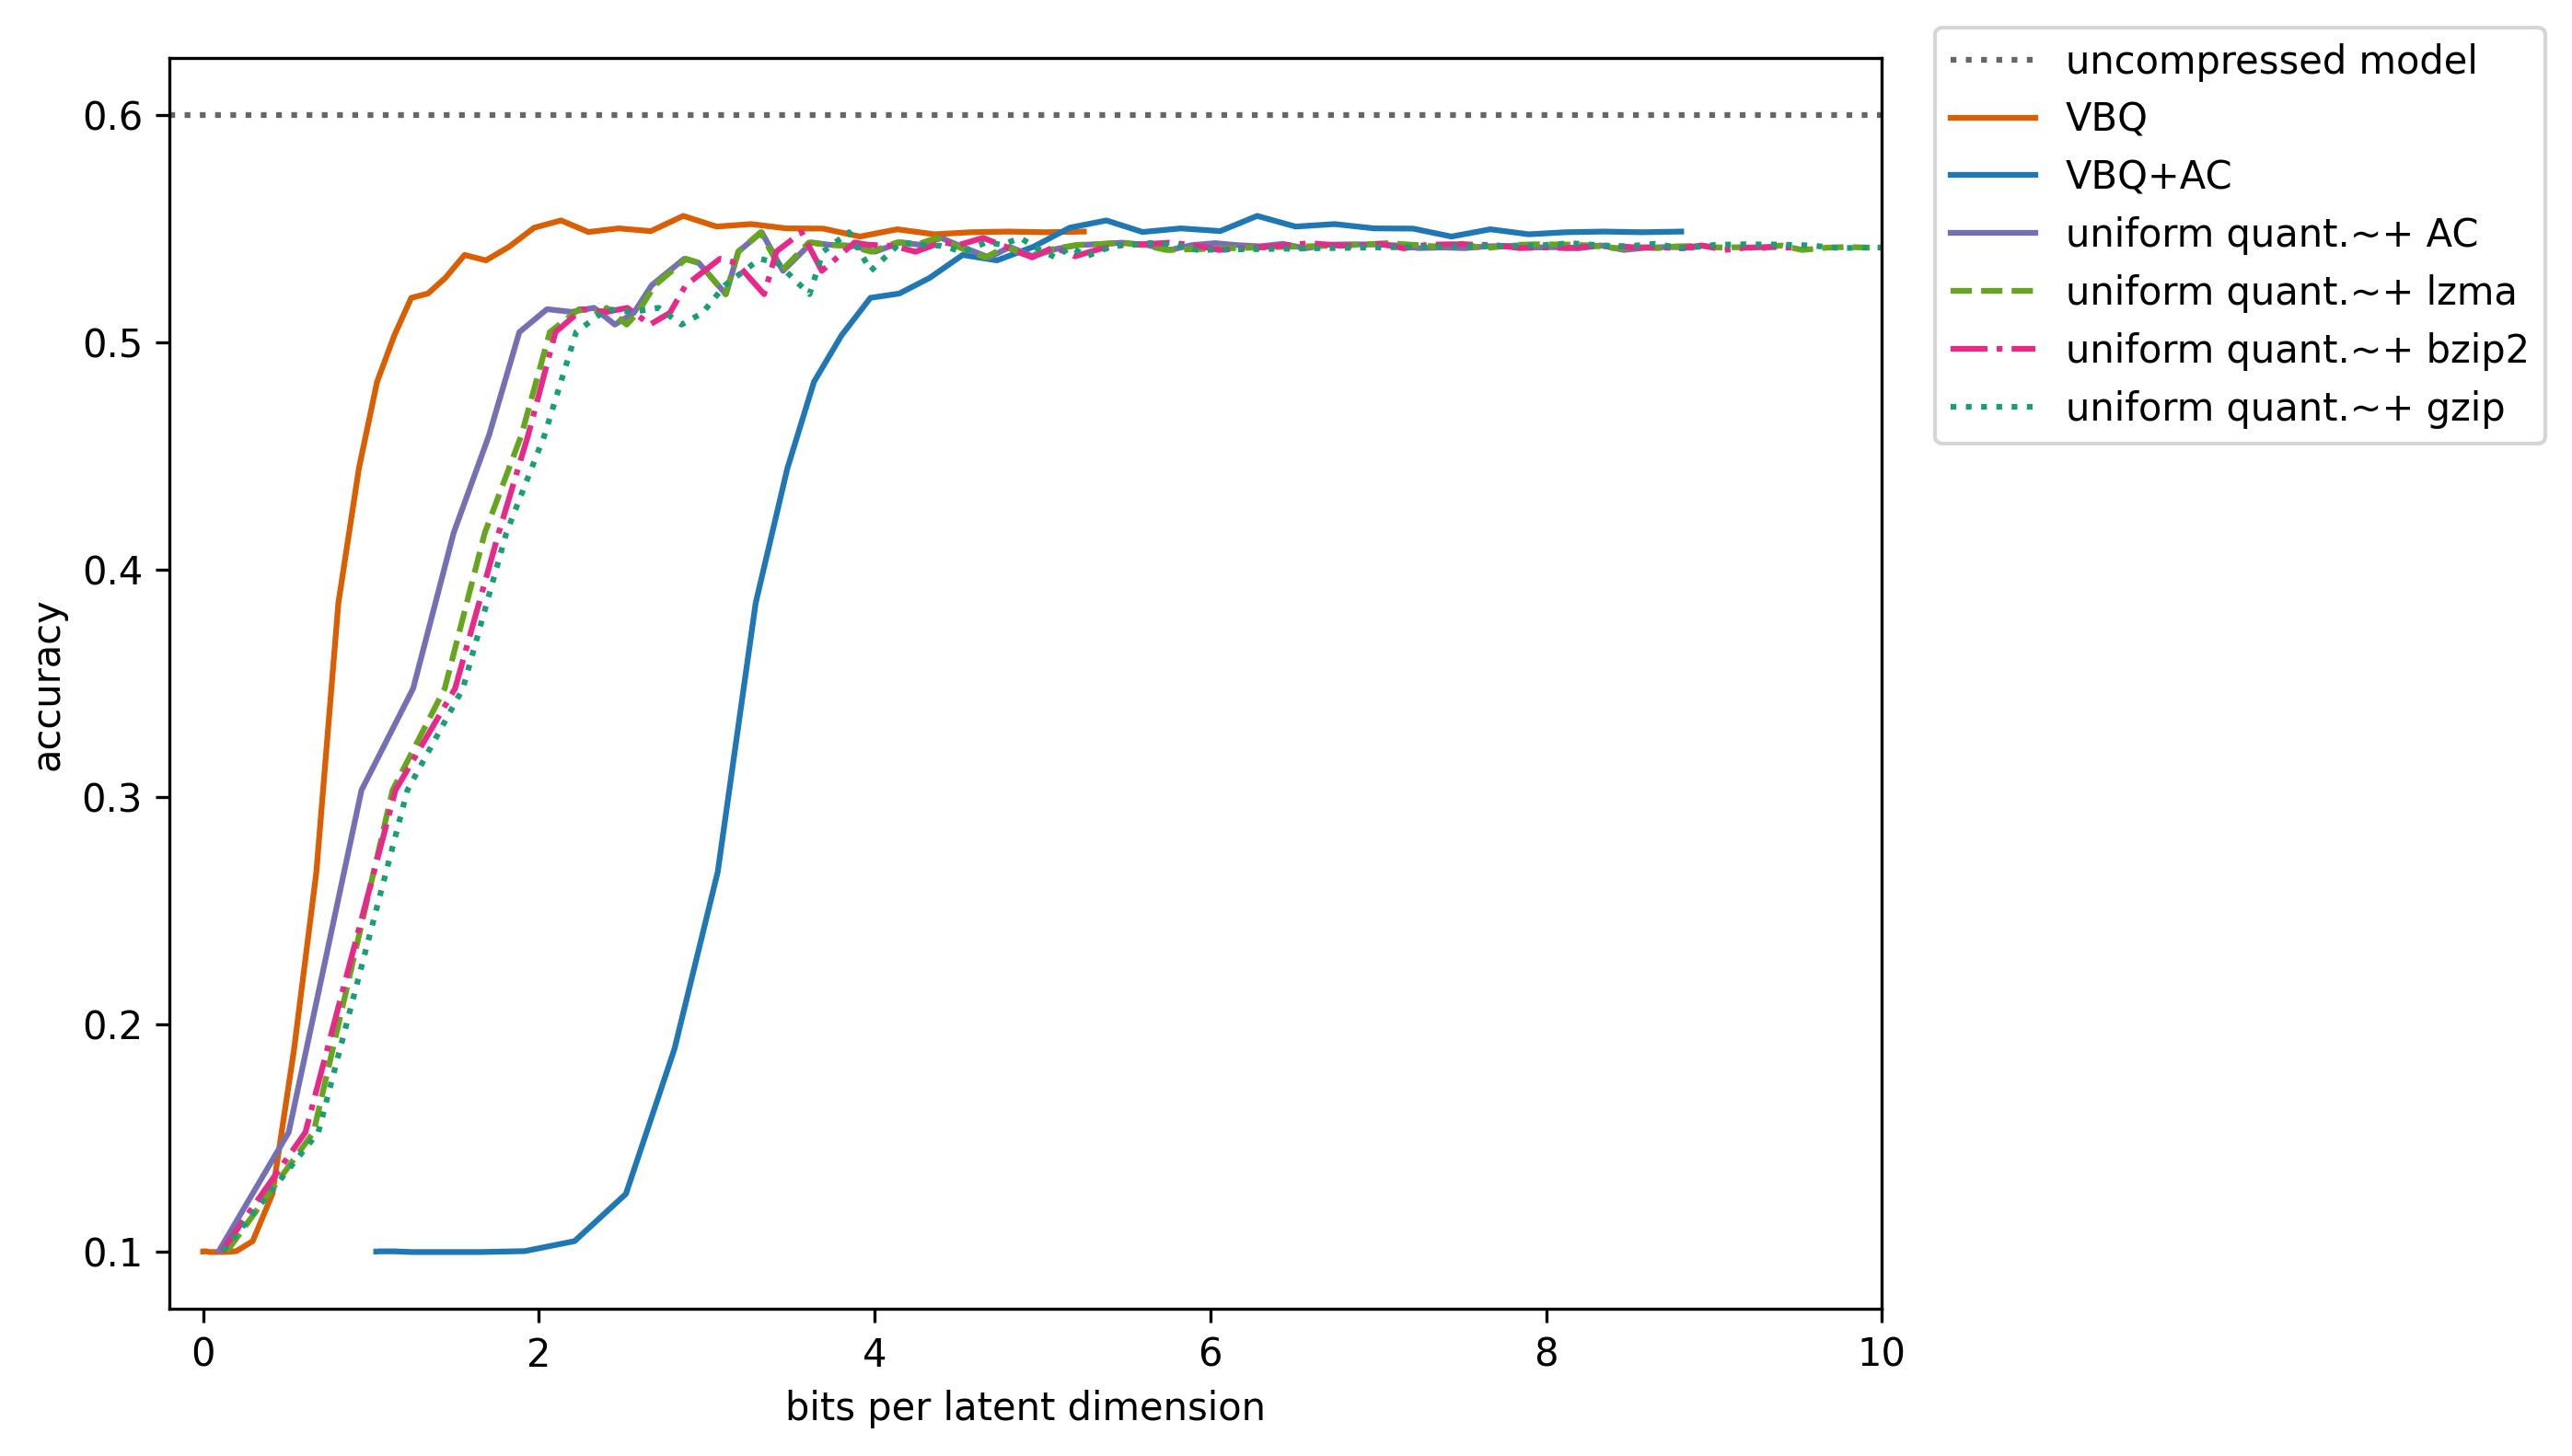

In [39]:
from matplotlib.ticker import AutoMinorLocator
plt.figure(figsize=(8, 6), dpi=300)
full_acc = 0.6
plt.axhline(full_acc, linestyle=':', color='#666666', label='uncompressed model')

num_dimensions = len(whole_w)

plt.plot(
    mrrs_and_bitlengths[:, 2] / num_dimensions,
    mrrs_and_bitlengths[:, 0],
    '-', label='VBQ', c='#d95f02')

plt.plot(
    mrrs_and_bitlengths[:, 1] / num_dimensions,
    mrrs_and_bitlengths[:, 0],
    '-', label='VBQ+AC')

plt.plot(
    mrrs_and_bitlengths_baseline[:, -4] / num_dimensions,
    mrrs_and_bitlengths_baseline[:, 0],
    '-', label='uniform quant.~+ AC', c='#7570b3')


plt.plot(
    mrrs_and_bitlengths_baseline[:, -1] / num_dimensions,
    mrrs_and_bitlengths_baseline[:, 0],
    '--', label='uniform quant.~+ lzma',  c='#66a61e')

plt.plot(
    mrrs_and_bitlengths_baseline[:, -2] / num_dimensions,
    mrrs_and_bitlengths_baseline[:, 0],
    '-.', label='uniform quant.~+ bzip2',  c='#e7298a')

plt.plot(
    mrrs_and_bitlengths_baseline[:, -3] / num_dimensions,
    mrrs_and_bitlengths_baseline[:, 0],
     ':', label='uniform quant.~+ gzip', c='#1b9e77')

plt.xlim(-0.2, 10)
plt.xlabel('bits per latent dimension')
plt.ylabel('accuracy')
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.04), labelspacing=0.5, handlelength=2.2)
